# 数据建模
## 当在调试环境中运行时
使用`保险数据集-训练 `抽样数据进行训练
使用`保险数据集-c测试 `抽样数据进行测试
## 当在全量环境中运行时
使用`保险数据集-训练 `全量数据进行训练
使用`保险数据集-c测试 `全量数据进行测试

### 构建baseline模型，Quadratic_Weighted_Kappa指标值为0.612

In [1]:
#导入必要的包

#计算与可视化
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#评估指标、编码与模型
from  sklearn.metrics import accuracy_score,  auc, confusion_matrix, roc_auc_score, classification_report,cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.optimize import fmin_powell
#from ml_metrics import quadratic_weighted_kappa

from wf_analyse.analyse import base

# 查看数据
## 字段说明：
* Ins_Age：申请人年龄（标准化处理过的结果）
* Ht：申请人身高（标准化处理过的结果）
* Wt：申请人体重（标准化处理过的结果）
* BMI：申请人身体健康指数（标准化处理过的结果）
* Product_Info_1-7：申请产品相关的变量（处理后的结果）
* Employment_Info_1-6：有关申请人工作经验的变量（处理后的结果）
* InsuredInfo_1-6：有关申请人的信息变量（处理后的结果）
* Insurance_History_1-9：有关申请人过去的保险信息（处理后的结果）
* Family_Hist_1-5:有关申请人家庭相关的信息（处理后的结果）
* Medical_History_1-41：有关申请人的医疗史信息（处理后的结果）
* Medical_Keyword_1-48：与该保险相关或不相关的医疗信息？？？不太确定含义，该信息是伪变量
* Response：响应值（1-8级：1，2，3，4，5，6，7，8）

## 字段类型说明：
* 连续值变量：
<p> Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5.<p> 

* 离散值变量：
<p> Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32
Medical_Keyword_1-48 are dummy variables.<p> 

* 无序的类别变量：
<p> Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41

In [2]:
# 导入数据集 insurance-train-sample
 
import wfio
_INPUT = '{"type":15,"uri":"awss3db9caeb9d16c4ef6ad5a8328c29f7dc7/sd_84fd224574b8485f8f119ea069af3977"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
train = wfio.read_dataframe(_INPUT,as_spark = False)

In [3]:
# 导入数据集 insurance-test-sample
 
import wfio
_INPUT = '{"type":15,"uri":"awss34c73b9d5f82d4b1886bba7962f09012e/sd_0dcbbe2a8c614b988f232a9db3283be1"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
test = wfio.read_dataframe(_INPUT,as_spark = False)

In [4]:
#查看训练集数据情况
print(train.info())  #"Product_Info_2是"object"类型的数据，其他字段均是数值型
print(train.columns)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 134 entries, empty_name to response
dtypes: float64(19), int64(109), object(6)
memory usage: 1.0+ MB
None
Index(['empty_name', 'name', 'sex', 'id_card', 'mobile_number', 'email',
       'addr', 'product_info_1', 'product_info_2', 'product_info_3',
       ...
       'medical_keyword_40', 'medical_keyword_41', 'medical_keyword_42',
       'medical_keyword_43', 'medical_keyword_44', 'medical_keyword_45',
       'medical_keyword_46', 'medical_keyword_47', 'medical_keyword_48',
       'response'],
      dtype='object', length=134)


,empty_name,name,sex,id_card,mobile_number,email,addr,product_info_1,product_info_2,product_info_3,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
0,4,周凡*,女,**************1925,1523119****,NaN,广东省揭阳市南九水*****-*-****,1,D3,26,...,0,0,0,0,0,0,0,0,0,6
1,10,陈辉*,男,**************2711,1495556****,NaN,广东省广州市泗水大*****-*-****,1,A8,26,...,0,0,0,0,0,0,0,0,0,6
2,11,孔*,女,**************9595,1808133****,NaN,福建省宁德市荷泽一*****-*-****,1,D2,26,...,0,0,0,0,0,0,0,0,0,8
3,24,陈民*,男,**************8909,1593789****,NaN,云南省丽江市福山支*****-*-****,1,D1,26,...,0,0,0,0,0,0,0,0,0,8
4,37,常云*,女,**************7589,1491701****,NaN,浙江省宁波市港夏街****-**-****,1,D4,10,...,0,0,1,0,0,1,0,0,0,8


In [5]:
#查看测试集数据情况
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 134 entries, empty_name to response
dtypes: float64(19), int64(109), object(6)
memory usage: 1.0+ MB


,empty_name,name,sex,id_card,mobile_number,email,addr,product_info_1,product_info_2,product_info_3,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
0,4,周*,男,**************2033,1590059****,NaN,云南省保山市澳门五*****-*-****,1,B2,29,...,0,0,0,0,0,0,0,0,0,8
1,5,王*,男,**************3658,1533579****,NaN,广东省茂名市蒲台大****-**-****,1,D4,26,...,0,0,0,0,0,0,0,0,0,1
2,10,冯*,男,**************4298,1558000****,NaN,云南省玉溪市龙江****-*-***-**,1,A2,26,...,0,0,0,0,0,0,0,0,1,6
3,11,李卿*,女,**************5653,1734403****,NaN,北京市丰台区冠县路***-**-*****,1,D1,26,...,0,0,0,0,0,0,0,0,0,8
4,17,杨媛*,女,**************2590,1363211****,NaN,北京市朝阳区仙山东****-*-*****,1,D3,26,...,0,0,0,0,0,0,0,0,0,6


In [6]:
#计算Quadratic_Weighted_Kappa指标值
def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y, weights= 'quadratic')

#计算准确率Accuracy
def acc(y, yhat):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return accuracy_score(y, yhat)

In [7]:
# 全局变量
columns_to_drop = ['response']
xgb_num_rounds = 700
num_classes = 8

In [8]:
test_label = test["response"].copy()
test["response"] = -1000
# 将训练集与测试集拼接，并于统一特征处理
all_data = train.append(test)

In [9]:
#删除无用字段特征
all_data.drop(["empty_name", 'name', "sex", "id_card","mobile_number", "email", "addr"], axis = 1, inplace=True)

In [10]:
# 创建新特征 
# 特征编码
all_data['product_info_2'] = pd.factorize(all_data['product_info_2'])[0]

print('Eliminate missing values')    
# 空值填充-1
all_data.fillna(-1, inplace=True)

# 将label转为int值
all_data['response'] = all_data['response'].astype(int)

Eliminate missing values


In [11]:
def get_params():
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 50
    params["subsample"] = 0.8
    params["colsample_bytree"] = 0.30
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())
    return plst

In [12]:
# 拆分数据集
train = all_data[all_data['response']>0].copy()
test = all_data[all_data['response']<1].copy()

In [13]:
# 转成xgb格式
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test_label.values)

# 获取模型参数
plst = get_params()

In [14]:
evals_process = dict()   #存储训练过程中的指标，便于后面loss曲线图

In [15]:
model = xgb.train(plst, xgtrain, xgb_num_rounds,evals=[(xgtrain, 'train'),(xgtest,'test')],verbose_eval=50, evals_result = evals_process)
#每50轮打印一次结果

[0]	train-rmse:5.40440	test-rmse:5.52076
[50]	train-rmse:2.00406	test-rmse:2.11947
[100]	train-rmse:1.78502	test-rmse:2.01948
[150]	train-rmse:1.67162	test-rmse:2.00312
[200]	train-rmse:1.57043	test-rmse:2.00007
[250]	train-rmse:1.47923	test-rmse:2.00329
[300]	train-rmse:1.39864	test-rmse:2.00804
[350]	train-rmse:1.32686	test-rmse:2.01660
[400]	train-rmse:1.26361	test-rmse:2.02228
[450]	train-rmse:1.20643	test-rmse:2.03056
[500]	train-rmse:1.14991	test-rmse:2.03621
[550]	train-rmse:1.10098	test-rmse:2.04436
[600]	train-rmse:1.05574	test-rmse:2.05413
[650]	train-rmse:1.01203	test-rmse:2.05873
[699]	train-rmse:0.97004	test-rmse:2.06115


In [16]:
len(evals_process['train']["rmse"])   #训练了700个epoch

700

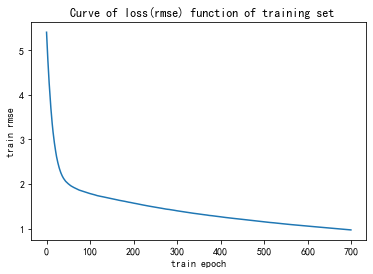

In [17]:
#绘制训练集的训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['train']["rmse"])
plt.ylabel('train rmse')
plt.xlabel('train epoch')
plt.title(" Curve of loss(rmse) function of training set")
plt.show()

In [18]:
#保存训练集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='train', norm_name='loss',norm_value=np.float(evals_process['train']["rmse"][i]),step=i)
    #print(evals_process['train']["rmse"][i])

saving 【train】【step:0】 loss : 5.404398
saving 【train】【step:1】 loss : 5.182468
saving 【train】【step:2】 loss : 4.979345
saving 【train】【step:3】 loss : 4.786365
saving 【train】【step:4】 loss : 4.598667
saving 【train】【step:5】 loss : 4.426486
saving 【train】【step:6】 loss : 4.265729
saving 【train】【step:7】 loss : 4.114908
saving 【train】【step:8】 loss : 3.967079
saving 【train】【step:9】 loss : 3.830273
saving 【train】【step:10】 loss : 3.697332
saving 【train】【step:11】 loss : 3.578123
saving 【train】【step:12】 loss : 3.462212
saving 【train】【step:13】 loss : 3.353871
saving 【train】【step:14】 loss : 3.252239
saving 【train】【step:15】 loss : 3.162905
saving 【train】【step:16】 loss : 3.076967
saving 【train】【step:17】 loss : 2.999495
saving 【train】【step:18】 loss : 2.923969
saving 【train】【step:19】 loss : 2.853571
saving 【train】【step:20】 loss : 2.787907
saving 【train】【step:21】 loss : 2.727762
saving 【train】【step:22】 loss : 2.667612
saving 【train】【step:23】 loss : 2.612676
saving 【train】【step:24】 loss : 2.563962
saving 【tr

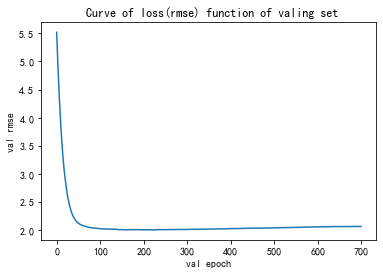

In [19]:
#绘制验证集在训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['test']["rmse"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('val rmse')
plt.xlabel('val epoch')
plt.title(" Curve of loss(rmse) function of valing set")
plt.show()

In [20]:
#全量数据保存
#保存测试集集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='validation', norm_name='loss',norm_value=np.float(evals_process['test']["rmse"][i]),step=i)
    #print(evals_process['test']["rmse"][i]

saving 【train】【step:0】 loss : 5.520755
saving 【train】【step:1】 loss : 5.29569
saving 【train】【step:2】 loss : 5.09186
saving 【train】【step:3】 loss : 4.897633
saving 【train】【step:4】 loss : 4.706938
saving 【train】【step:5】 loss : 4.532319
saving 【train】【step:6】 loss : 4.368584
saving 【train】【step:7】 loss : 4.216132
saving 【train】【step:8】 loss : 4.066803
saving 【train】【step:9】 loss : 3.924871
saving 【train】【step:10】 loss : 3.788677
saving 【train】【step:11】 loss : 3.666839
saving 【train】【step:12】 loss : 3.551698
saving 【train】【step:13】 loss : 3.442247
saving 【train】【step:14】 loss : 3.339149
saving 【train】【step:15】 loss : 3.247961
saving 【train】【step:16】 loss : 3.159917
saving 【train】【step:17】 loss : 3.080871
saving 【train】【step:18】 loss : 3.008141
saving 【train】【step:19】 loss : 2.939654
saving 【train】【step:20】 loss : 2.875937
saving 【train】【step:21】 loss : 2.816248
saving 【train】【step:22】 loss : 2.752086
saving 【train】【step:23】 loss : 2.697855
saving 【train】【step:24】 loss : 2.64729
saving 【train

In [21]:
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train kappa score is:', eval_wrapper(train_preds, train['response']))
print('Train accuracy score is:', acc(train["response"], train_preds))

test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
print('Test kappa score is:', eval_wrapper( test_preds, test_label))

Train kappa score is: 0.9001089336246018
Train accuracy score is: 0.449
Test kappa score is: 0.5129443398861278


In [22]:
#全量数据指标保存
#base.save_norm(model_name='xgbregression', norm_name='auc',norm_value=np.float(acc(train["response"], train_preds)), operate_type='train')   
#base.save_norm(model_name='xgbregression', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper(train_preds, train['response'])), operate_type='train')              
base.save_norm(model_name='xgbregression', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper( test_preds, test_label)), operate_type='test')           

saving 【test】 Quadratic_Weighted_Kappa : 0.5129443398861278
